<a href="https://colab.research.google.com/github/vethssvikas/Emotions-in-Speech/blob/main/work_on_ravdess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import soundfile # to read audio file
import numpy as np
import pandas as pd
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Mounting Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading RAVDESS

In [ ]:
# CREATE DIRECTORY OF AUDIO FILES 
audio ='/content/gdrive/My Drive/ravdess_data/'
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

# Analyzing RAVDESS using a dataframe format

In [ ]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + '/' + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [ ]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

,gender,emotion,actor,path
0,male,neutral,1,/content/gdrive/My Drive/ravdess_data/Actor_01...
1,male,neutral,1,/content/gdrive/My Drive/ravdess_data/Actor_01...
2,male,calm,1,/content/gdrive/My Drive/ravdess_data/Actor_01...
3,male,calm,1,/content/gdrive/My Drive/ravdess_data/Actor_01...
4,male,happy,1,/content/gdrive/My Drive/ravdess_data/Actor_01...
...,...,...,...,...
1435,female,surprise,24,/content/gdrive/My Drive/ravdess_data/Actor_24...
1436,female,disgust,24,/content/gdrive/My Drive/ravdess_data/Actor_24...
1437,female,disgust,24,/content/gdrive/My Drive/ravdess_data/Actor_24...
1438,female,surprise,24,/content/gdrive/My Drive/ravdess_data/Actor_24...


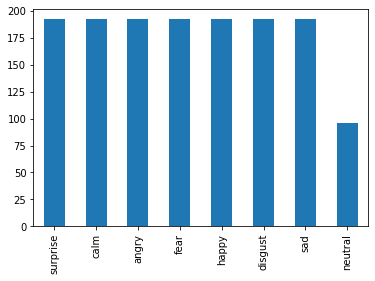

In [ ]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='bar')

In [ ]:
audio_df['path'][0]

'/content/gdrive/My Drive/ravdess_data/Actor_01/03-01-01-01-01-01-01.wav'

In [ ]:
emotions = {'neutral', 'angry' , 'happy', 'sad'}
path = []
emotion = []
for i in range(1440):
    if (audio_df['emotion'][i] not in emotions):
      continue
    else:
       path.append(audio_df['path'][i])
       emotion.append(audio_df['emotion'][i])
    

In [ ]:
final_df = pd.DataFrame(columns=['path', 'emotion'])
final_df['path'] = path
final_df['emotion'] = emotion

In [ ]:
final_df

,path,emotion
0,/content/gdrive/My Drive/ravdess_data/Actor_01...,neutral
1,/content/gdrive/My Drive/ravdess_data/Actor_01...,neutral
2,/content/gdrive/My Drive/ravdess_data/Actor_01...,happy
3,/content/gdrive/My Drive/ravdess_data/Actor_01...,angry
4,/content/gdrive/My Drive/ravdess_data/Actor_01...,happy
...,...,...
667,/content/gdrive/My Drive/ravdess_data/Actor_24...,angry
668,/content/gdrive/My Drive/ravdess_data/Actor_24...,angry
669,/content/gdrive/My Drive/ravdess_data/Actor_24...,angry
670,/content/gdrive/My Drive/ravdess_data/Actor_24...,angry


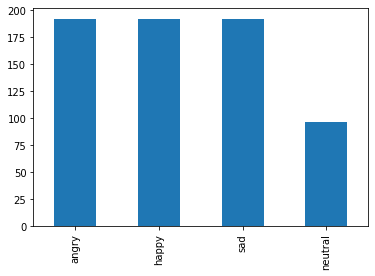

In [ ]:
# LOOK AT DISTRIBUTION OF CLASSES
final_df.emotion.value_counts().plot(kind='bar')

# Function for extracting features

In [ ]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [ ]:
X = []
y = []
for i in range(672):
   c
    features = extract_feature(final_df['path'][i], mfcc=True, chroma=True, mel=True)
    X.append(features)


In [ ]:
trainfeatures, trainlabel, testfeatures, testlabel = train_test_split(np.array(X), y, test_size=0.2, random_state=7)

In [ ]:
X_train = np.array(trainfeatures)
X_test = np.array(trainlabel)
y_train = np.array(testfeatures)
y_test = np.array(testlabel)

In [ ]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
X_train.shape

(537, 180)

In [ ]:
y_train.shape

(537, 4)

In [ ]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
import tensorflow
from tensorflow.keras import optimizers

In [ ]:
model = Sequential()


model.add(Conv1D(256, 5,padding='same',
                 input_shape=(180,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [ ]:
model.summary()

In [ ]:

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 80.74%


In [ ]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

5/5 [==============================] - 0s 35ms/step


In [ ]:

preds1=preds.argmax(axis=1)

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:

preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,angry
1,sad
2,happy
3,sad
4,angry
5,neutral
6,sad
7,angry
8,happy
9,angry


In [ ]:

actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,sad
1,sad
2,happy
3,happy
4,angry
5,sad
6,happy
7,angry
8,angry
9,angry


In [ ]:
finaldf = actualdf.join(preddf)
finaldf

,actualvalues,predictedvalues
0,sad,angry
1,sad,sad
2,happy,happy
3,happy,sad
4,angry,angry
...,...,...
130,happy,happy
131,sad,sad
132,sad,sad
133,sad,sad


In [ ]:
# best model, determined by a grid search
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}

In [ ]:
model = MLPClassifier(**model_params)
# train the model
print("[*] Training the model...")
model.fit(X_train, y_train)

[*] Training the model...


MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# predict 25% of data to measure how good we are
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 37.04%
